|Name|Student ID|
|:--|:--|
|Caitao Zhan|111634527|

|Table of|Contents|
|:-- |:--|
|1   |Data Cleaning & Visualization |
|1.1 |Data Summary|
|1.2 |Group by Rating|
|1.3 |Group by Customer|
|1.4 |Group by Movie|
|2   |SVD|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
import re
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD

# 1 Data Cleaning & Visualization

## 1.1 Data Summary

The data is very big (according to RAM). Instead of importing all four data sets, I will only import only one of the four to do some visualization so that I can get some quick feeling and intuition on the data.

In summery, in the first dataset (combined_data_1.txt), there are over **24 million** rows. Every row has **3** columns. Actually, there is a conceptually **4th** column, but it is at the first line of each new movie, followed by a colon, not a comma.

**Features**:

1. Customer ID
2. Rating
3. Date of the rating
4. Movie ID

To begin with, visualize the **customer** and **rating** feature. Only using data from the **first data file**, about 1/4 of all movies.

In [41]:
df1 = pd.read_csv('../data/combined_data_1.txt', names = ['Customer', 'Rating'])

In [4]:
df1.shape

(24058263, 2)

In [5]:
movie_num = df1.isnull().sum()[1]

In [6]:
df1_clean = df1.dropna(how='any')

In [7]:
customer_num = df1_clean['Customer'].nunique()

In [8]:
rating_num = df1_clean['Rating'].count()

In [9]:
print('movie number = %d, customer number = %d, rating counts = %d' %(movie_num, customer_num, rating_num))

movie number = 4499, customer number = 470758, rating counts = 24053764


## 1.2 Group by Ratings

In [10]:
rating_group = df1_clean.groupby('Rating').count()

In [11]:
rating_group

,Customer
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


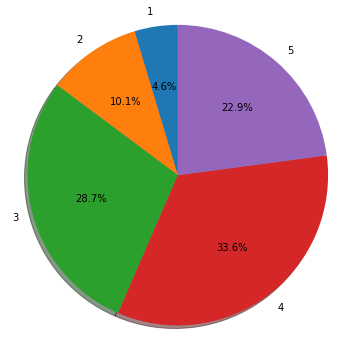

In [12]:
fig1, ax1 = plt.subplots(figsize=(6,6))
labels = '1', '2', '3', '4', '5'
ax1.pie(rating_group, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

**4-point** rating is the most with about **8 million** accounting **33.6%**. **1-point** is the least with about **1 million** accounting **4.6%**.

## 1.3 Group by Customers

In [13]:
customer_group = df1_clean.groupby('Customer').count()

In [14]:
customer_group.describe()

,Rating
count,470758.000000
mean,51.095816
std,74.405055
min,1.000000
25%,8.000000
50%,24.000000
75%,64.000000
max,4467.000000


In [15]:
customer_group_rating = np.log2(customer_group.Rating)

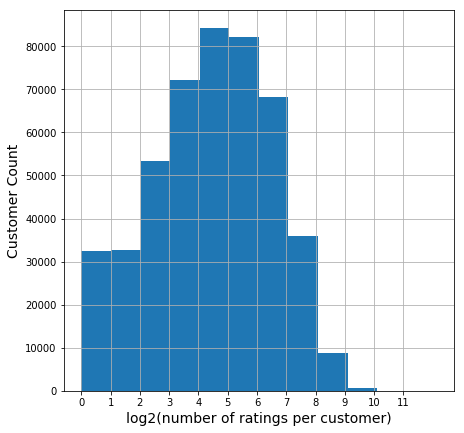

In [16]:
ax = customer_group_rating.plot.hist(bins=12, figsize=(7,7))
ax.set_xlabel('log2(number of ratings per customer)', fontsize=14)
ax.set_ylabel('Customer Count', fontsize=14)
ax.set_xticks(range(0,12))
ax.grid()

From the figure, there is about **36,000** customers who rated **128~256** ($log_2{128}=7$) movies. We do a logarithm on the number of ratings per customer to make the plot looks better.

## 1.4 Group by Movie

Movie ID does not show up in every row of the dataset, so we need to solve it by adding the Movie ID to each row.

In [42]:
df = df1

In [18]:
df_movie = pd.DataFrame(pd.isnull(df.Rating))
df_movie = df_movie[df_movie['Rating']==True]
df_movie = df_movie.reset_index()

In [19]:
df_movie.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [20]:
movie_ids = []
movie_id  = 1

for i,j in zip(df_movie['index'][1:], df_movie['index'][:-1]):
    tmp = np.full((1, i-j-1), movie_id)
    movie_ids = np.append(movie_ids, tmp)
    movie_id = movie_id +1

In [21]:
last_movie = np.full((1, len(df) - df_movie.iloc[-1, 0] -1), movie_id)
movie_ids = np.append(movie_ids, last_movie)

In [43]:
df.shape

(24058263, 2)

In [ ]:
df = df.dropna()
df['Movie'] = movie_ids.astype(int)
df['Customer'] = df['Customer'].astype(int)

In [28]:
df.shape

(24053764, 3)

In [29]:
movie_group = df.groupby('Movie').count()

In [30]:
movie_group_customer = np.log2(movie_group.Customer)

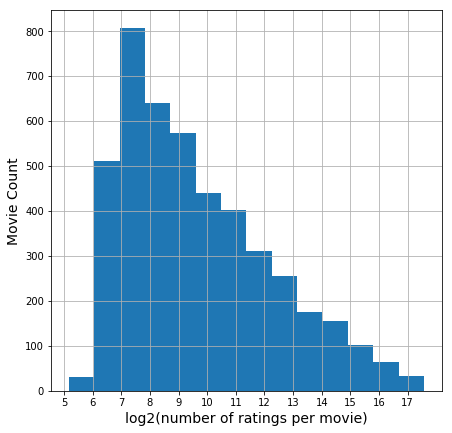

In [31]:
ax = movie_group_customer.plot.hist(bins=14, figsize=(7,7))
ax.set_xlabel('log2(number of ratings per movie)', fontsize=14)
ax.set_ylabel('Movie Count', fontsize=14)
ax.set_xticks(range(5,18))
ax.grid()

From the plot, there is about **510** movies who received **64~128** ($log_2{64}=6$) ratings

Import movie title file.

In [32]:
df_title = pd.read_csv('../data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


## 1.5 Memory Error

The data is too large for a PC, so large that the program generates a memory error. So we decide to reduce the size of the data by two ways:

1. Delete movies that have few reviews
2. Delete customer who give few reviews to movies

This means we are going to remove the unpopular movies less active customers.

In [33]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie')['Rating'].agg(f)
movie_min = df_movie_summary['count'].quantile(0.75)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_min].index

df_cust_summary = df.groupby('Customer')['Rating'].agg(f)
cust_min = df_cust_summary['count'].quantile(0.75)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_min].index

In [34]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie'].isin(drop_movie_list)]
df = df[~df['Customer'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (24053764, 3)
After Trim Shape: (15622656, 3)


# 2 SVD

In [35]:
reader = Reader()

data = Dataset.load_from_df(df[['Customer', 'Movie', 'Rating']], reader)
data.split(n_folds=5)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8424
MAE:  0.6551
------------
Fold 2
RMSE: 0.8413
MAE:  0.6536
------------
Fold 3
RMSE: 0.8425
MAE:  0.6548
------------
Fold 4
RMSE: 0.8422
MAE:  0.6547
------------
Fold 5
RMSE: 0.8418
MAE:  0.6544
------------
------------
Mean RMSE: 0.8420
Mean MAE : 0.6545
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.65506407368498176,
                             0.65359055517938269,
                             0.65479698248951879,
                             0.65467854200878495,
                             0.65438153512888086],
                            'rmse': [0.84241760166685109,
                             0.84129344780308579,
                             0.84246032545798832,
                             0.84221359946950514,
                             0.84177094130067442]})

In [40]:
reader = Reader()

# use top 1 miilion rows for faster run time
data = Dataset.load_from_df(df[['Customer', 'Movie', 'Rating']][:1000000], reader)
data.split(n_folds=5)

svd2 = SVD()

evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9543
MAE:  0.7504
------------
Fold 2
RMSE: 0.9553
MAE:  0.7499
------------
Fold 3
RMSE: 0.9532
MAE:  0.7484
------------
Fold 4
RMSE: 0.9531
MAE:  0.7486
------------
Fold 5
RMSE: 0.9531
MAE:  0.7481
------------
------------
Mean RMSE: 0.9538
Mean MAE : 0.7491
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.75042068561765363,
                             0.74985779200788316,
                             0.74839693189957646,
                             0.7485765880122599,
                             0.7481245974639934],
                            'rmse': [0.95431611193277577,
                             0.95525588477229062,
                             0.95323560753103642,
                             0.95312361718186855,
                             0.95308655027063727]})

In [45]:
reader = Reader()

data = Dataset.load_from_df(df[['Customer', 'Movie', 'Rating']], reader)
data.split(n_folds=5)

svd3 = SVD()

evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9001
MAE:  0.6948
------------
Fold 2
RMSE: 0.9006
MAE:  0.6956
------------
Fold 3
RMSE: 0.9002
MAE:  0.6948
------------
Fold 4
RMSE: 0.9002
MAE:  0.6947
------------
Fold 5
RMSE: 0.8994
MAE:  0.6943
------------
------------
Mean RMSE: 0.9001
Mean MAE : 0.6948
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.69479141702891523,
                             0.69560934471361735,
                             0.69482784596969116,
                             0.69467743903260792,
                             0.694302300745682],
                            'rmse': [0.90012200049746482,
                             0.90059121844238443,
                             0.90021392861142135,
                             0.90016970951907371,
                             0.89942497737510008]})